# Time Series Analysis & Forecasting of New Home Sales

## Table of Contents
1. Introduction
2. Objectives
3. Data & Methods  
4. Results  
    4.1 Exploratory Data Analysis (EDA)  
    4.2 Forecasting
        4.2.1 Input data & decomposition  
        4.2.2 Forecasting with HW Exponential Smoothing  
        4.2.3 Forecasting with ETS  
        4.2.4 Forecasting with ARIMA   
5. Discussion & Conclusion  
    5.1 Model evaluation  
    5.2 General conclusions  
    5.3 Discussion
   

## 1. Introduction
New house construction & sales play a significant role in housing economy. Besides generating employment it simultaneously  impacts timber, furniture and appliance markets. It's an important indicator of country's overall economic health too. Over the last 50 years, as we will see below, there has been few significant bumps and turning points in housing market, which shaped the trajectory of the US economy.  

## 2. Objectives
The objectives of this analysis are two-fold: (1) review and discuss historical patterns in new home sales; and (2) test different forecasting models and run short-term forecasting of new home sales. 

## 3. Data & methods
- The time series data I am working with comes from [census.gov](https://bit.ly/2Sp1ALz). This is a great source for time series data sets on a large number of social, economic and business indicators. 
- I downloaded the "New Singly-Family House Sold" series. This is not seasonally adjusted, but there is one such series called "Annual Rate of Single-Family House Sold", which has already gone through some data treatments already for seasonal adjustments, so I rather prefered the "raw" data instead, which is reported monthly and not adjusted. 
- Key terms in this dataset are "new", "single-family house" and "sold". [Check out](https://www.census.gov/construction/nrs/definitions/index.html) the definition of these and other related terms. 
- I am doing the analysis in R. Although Python has great `ts` [resources](https://www.statsmodels.org), but for forecasting R has the best package, `forecast`, developed by Rob J Hyndman. 

In [1]:
# Required packages
library(fpp2)
library(forecast)
library(readxl)
library(ggplot2)
library(seasonal)
library(dplyr)

options(warn=0)

Loading required package: ggplot2
Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [3]:
# data import
df = read.csv("C:/Users/DataS/Google Drive/Python/Datasets/usnewhousesold.csv", skip=6)
head(df)[1:3,]

Period,Value
Jan-1963,42
Feb-1963,35
Mar-1963,44


In [4]:
# keep only `Value` column
df = df[, c(2)]

In [271]:
# convert the values into a time series object
series = ts(df, start = 1963, frequency =12)

## 4. Results

### 4.1 EDA

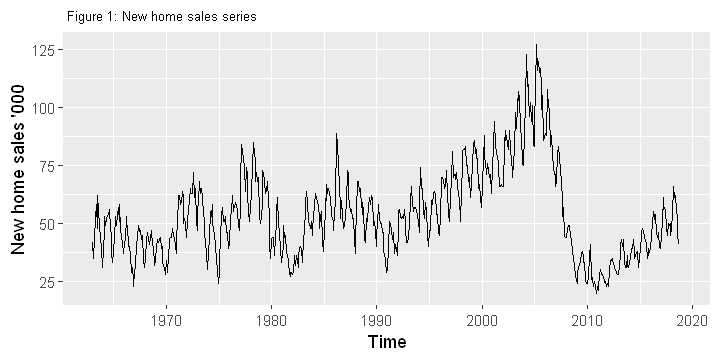

In [578]:
options(repr.plot.width = 6, repr.plot.height = 3)

# plot the series
autoplot(series)+ 
xlab("Time") + ylab("New home sales '000") + ggtitle(" Figure 1: New home sales series")+
theme(plot.title = element_text(size=8))

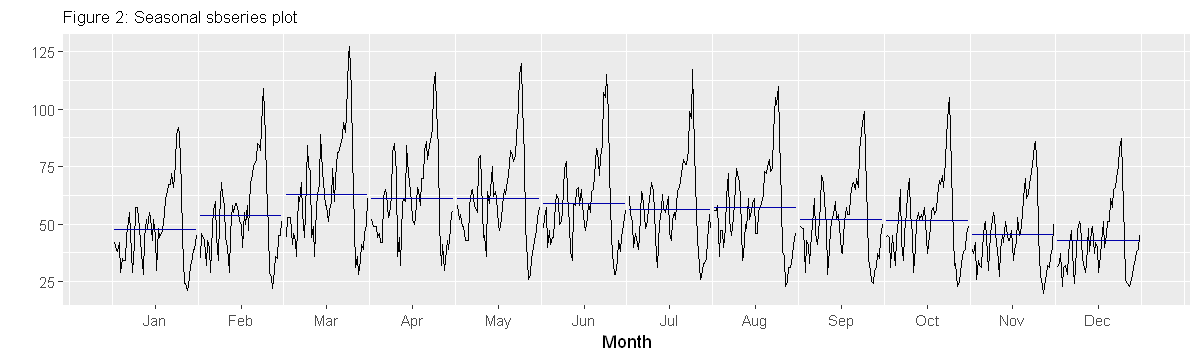

In [583]:
# Seasonal sub-series plot (the horizontal bar indicates montly mean values)
options(repr.plot.width = 10, repr.plot.height = 3)

series_season = window(series, start=c(1963,1), end=c(2017,12))
ggsubseriesplot(series_season) + ylab(" ") +
ggtitle("Figure 2: Seasonal sbseries plot")+
theme(plot.title = element_text(size=10))

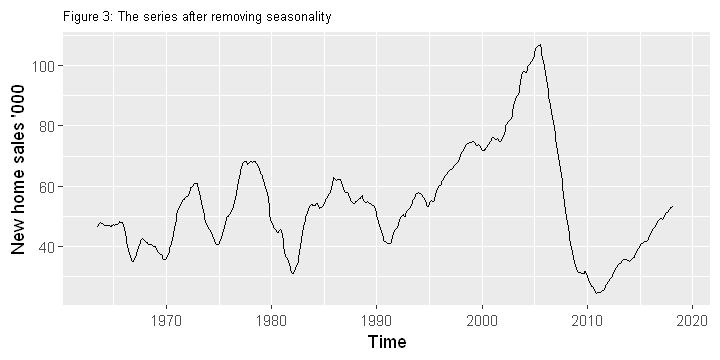

In [590]:
options(repr.plot.width = 6, repr.plot.height = 3)

# remove seasonality (monthly variation) to see yearly changes
series_ma = ma(series, 12)
autoplot(series_ma) + 
xlab("Time") + ylab("New home sales '000")+
ggtitle("Figure 3: The series after removing seasonality" )+
theme(plot.title = element_text(size=8))

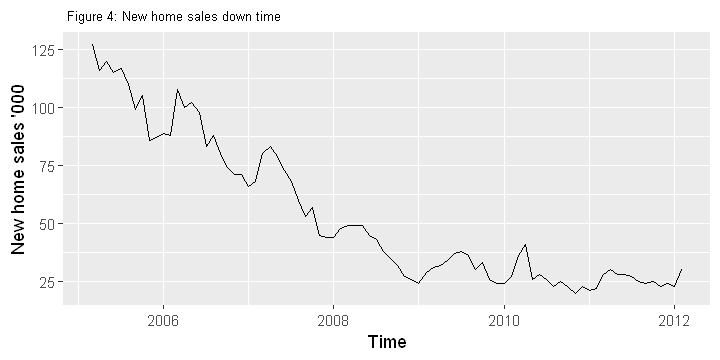

In [593]:
options(repr.plot.width = 6, repr.plot.height = 3)

# zooming in to the down time, which is clearly between 2005 to 2012
series_downtime = window(series, start=c(2005,3), end=c(2012,2))
autoplot(series_downtime) + 
xlab("Time") + ylab("New home sales '000")+
ggtitle(" Figure 4: New home sales down time")+
theme(plot.title = element_text(size=8))

**EDA Summary**
- Figure 1 shows clear seasonality all through, with a bit of cyclic pattern.
- In terms of seasonality, not surprisingly, home sales starts to go up in the spring, peaks during summer, then goes down in the fall. This is predictable in most years, except the years between 2005-2012 (Figure 1 & 3).
- After removing seasonality few things stand out (figure 3): there wasn't much movement (i.e. trend) in new home sales until 1990, other than the seasonality and a vague 4-5 year cycle. Post-1990 the market saw a boom, a steady growth that continued until 2005 - and which is when the market started to crash. The downward spiral continues for 8 years until 2012 (Figure 4). There has been a recovery since then with another steady growth, and with predictable seasonality (also see Figure 5), but with no cyclic patterns (mimicking 1990-2005).
- Sales were down more than 80% from average 127k/month to 23k/month during the "crash" years. Currently at 52k/month the sales is still 60% down compared to pre-2005 sales.

## 4.2 Forecasting
- In time series forecasting historical data is used as predictors of future values. But from Figure 3 it is clear that the distant past isn't any good in predicting the next 5-10 years. It is also clear that the segment in this series which may be useful for prediction is post-2012\ data (but see the [Appendix](#appendix) for prediction with the whole series)
- Decomposed data shows a predictable seasonality and trend component (Figure 6), so any complex modeling doesn't seem necessary. A Holt Winter Exponential smoothing or ARIMA should work just fine for forecasting. Nevertheless, I'm using 3 different methods to compare: ETS, HW Exponential Smoothing and ARIMA. There are plenty of literature on the internet on these forecasting methods, so I'm not going to discuss them ([and there is another good reason for not discussing theories!](https://data2decision.net/2018/11/16/learning-data-science-by-examples-rather-than-theories/)).


### 4.2.1 Input data & Decomposition

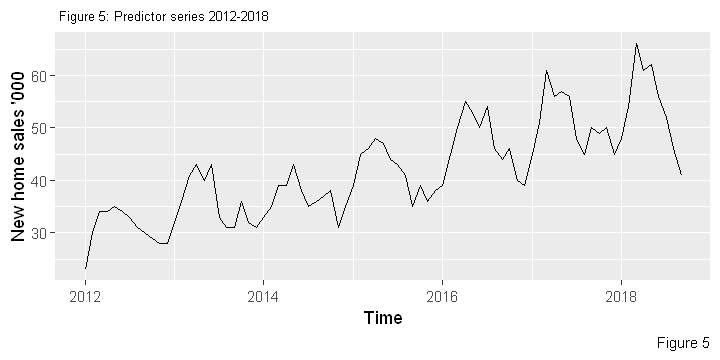

In [594]:
options(repr.plot.width = 6, repr.plot.height = 3)

# slicing 2012-2018 data as predictor series
onwards2012 = window(series, start=c(2012,1), end=c(2018,9))
autoplot(onwards2012) + labs(caption="Figure 5")+ xlab("Time") + ylab("New home sales '000")+
ggtitle(" Figure 5: Predictor series 2012-2018")+
theme(plot.title = element_text(size=8))

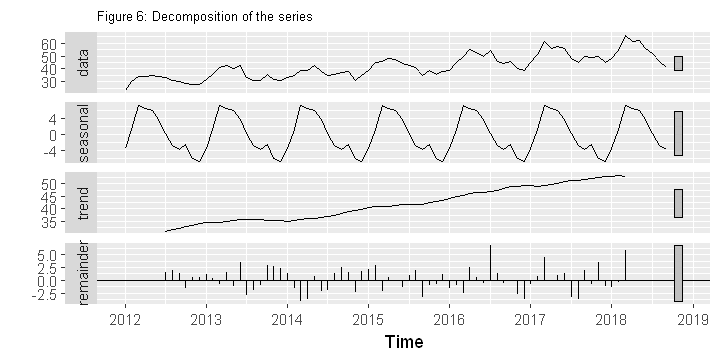

In [601]:
# decomposition
options(repr.plot.width = 6, repr.plot.height = 3)
autoplot(decompose(onwards2012)) + ggtitle("Figure 6: Decomposition of the series")+
theme(plot.title = element_text(size=8))


### 4.2.2 Forecasting with HW Exponential Smoothing

In [462]:
# model
forecast_hw=hw(onwards2012, seasonal="multiplicative", h=63)

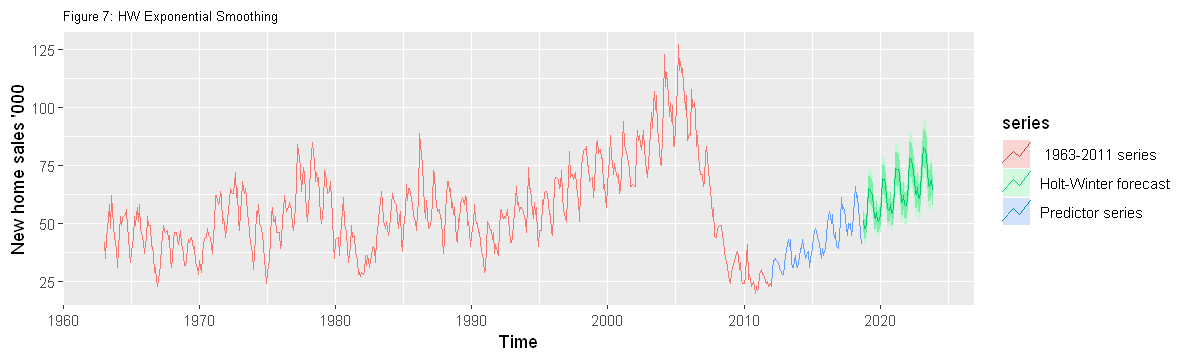

In [595]:
options(repr.plot.width = 10, repr.plot.height = 3)

# plot
autoplot(series, series = " 1963-2011 series")+ 
autolayer(onwards2012, series = "Predictor series")+
autolayer(forecast_hw, series="Holt-Winter forecast")+
 xlab("Time") + ylab("New home sales '000")+
ggtitle("Figure 7: HW Exponential Smoothing")+
theme(plot.title = element_text(size=8))

In [602]:
# point forecast for 2023 annual sales of new homes
forecast2023hw=tail(forecast_hw$mean, n=12)
forecast2023hw = sum(forecast2023hw)
round(forecast2023hw)

[1] 866

In [464]:
# Diagnostics/accuracy test
accuracy(forecast_hw)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.04761822,2.599018,1.989132,-0.443716,4.86829,0.424923,0.2685747


In [465]:
# model description
forecast_hw['model']

$model
Holt-Winters' multiplicative method 

Call:
 hw(y = onwards2012, h = 63, seasonal = "multiplicative") 

  Smoothing parameters:
    alpha = 0.083 
    beta  = 1e-04 
    gamma = 2e-04 

  Initial states:
    l = 28.5117 
    b = 0.3191 
    s = 0.8684 0.8786 0.943 0.904 0.9184 1.0028
           1.102 1.1405 1.1509 1.1622 1.0222 0.9071

  sigma:  0.0685

     AIC     AICc      BIC 
539.6391 549.3534 580.3448 


### 4.2.3 Forecasting with ETS method

In [466]:
# model
forecast_ets = forecast(onwards2012, h=63)

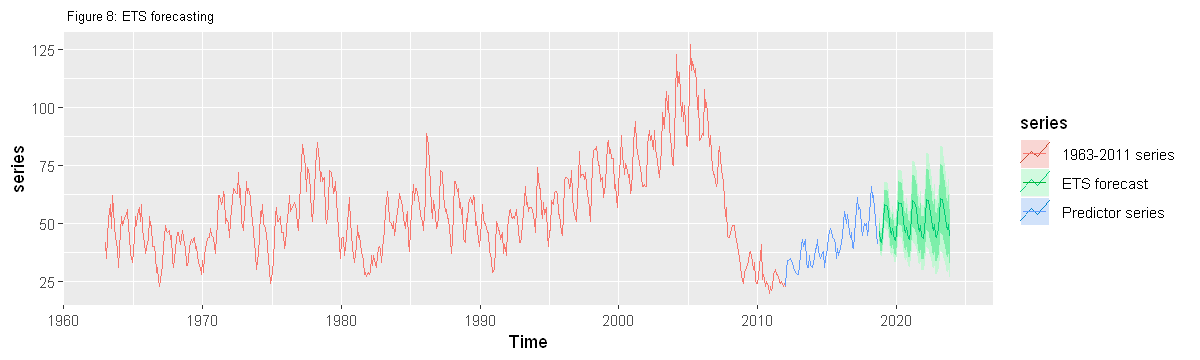

In [596]:
options(repr.plot.width = 10, repr.plot.height = 3)

# plot
autoplot(series, series=" 1963-2011 series")+
autolayer(forecast_ets, series=" ETS forecast")+
autolayer(onwards2012, series=" Predictor series")+
ggtitle(" Figure 8: ETS forecasting")+
theme(plot.title = element_text(size=8))

In [468]:
# point forecast
forecast2023ets=tail(forecast_ets$mean, n=12)
forecast2023ets = sum(forecast2023ets)
round(forecast2023ets)


[1] 628

In [469]:
# model diagnostics
accuracy(forecast_ets)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01218177,2.443436,1.880336,-0.3345021,4.560613,0.4016816,0.02412555


In [470]:
# model description
forecast_ets['model']

$model
ETS(M,Ad,M) 

Call:
 ets(y = object, lambda = lambda, biasadj = biasadj, allow.multiplicative.trend = allow.multiplicative.trend) 

  Smoothing parameters:
    alpha = 0.3755 
    beta  = 1e-04 
    gamma = 1e-04 
    phi   = 0.9786 

  Initial states:
    l = 28.3077 
    b = 0.5548 
    s = 0.8442 0.8563 0.9481 0.9062 0.934 1.0062
           1.0938 1.152 1.1577 1.167 1.0264 0.9081

  sigma:  0.066

     AIC     AICc      BIC 
534.3067 545.3390 577.4068 


### 4.2.4 Forecasting with ARIMA

In [443]:
# model
fit.arima = auto.arima(onwards2012, seasonal=TRUE, stepwise = FALSE, approximation = FALSE) 
forecast_arima = forecast(fit.arima, h=63)

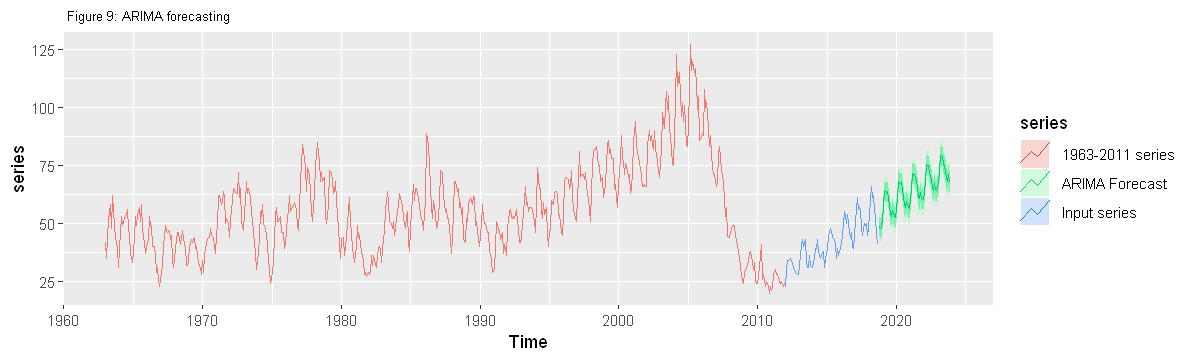

In [597]:
options(repr.plot.width = 10, repr.plot.height = 3)

# plot
autoplot(series, series=" 1963-2011 series")+
autolayer(onwards2012, series=" Input series")+
autolayer(forecast_arima, series=" ARIMA Forecast")+
ggtitle(" Figure 9: ARIMA forecasting")+
theme(plot.title = element_text(size=8))

In [292]:
# point forecast
forecast2023arima=tail(forecast_arima$mean, n=12)
forecast2023arima = sum(forecast2023arima)
cat("New house sold in 2023 ('000): ", round(forecast2023arima)) 

print('')

# current
cat(" Current value ('000): ", sum(tail(onwards2012, n=12)))


New house sold in 2023 ('000):  871[1] ""
 Current value ('000):  630

In [290]:
# diagnostics
accuracy(fit.arima)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.00559027,2.700185,1.896309,-0.3889919,4.354831,0.4050939,-0.04456412


In [291]:
# AIC
fit.arima$aic

[1] 364.973

## 5. Model evaluation and Conclusion

** Model comparison **
- AIC
    - HW: 539.6391 
    - ETS: 534.3067 
    - ARIMA: 364.97
- MAE
    - HW: 1.989132
    - ETS: 1.880336
    - ARIMA: 1.896309 

**Main conclusions**
- No growth happened in new home sales from 1960s for 30 years until 1990. Then started to climb up until 2005 before starting to collapse in 2005.
- New home sales declined by 75% in the 5 years between 2005 and 2010
- Sales is recovering since 2012, yet far from the pre-collapse sales
- Current sales it about 630k new homes per year
- 5-year forecast until 2023 shows total home sales at 870k - a total growth of about 40% (7% per year). This is a business-as-usual scenario, i.e., IF the everything goes as is. 
- The projected growth is still not even close toe pre-2005 level (>1200k/year). It can take, in the curent trend, 2035 to catch up to 2005 level

### Discussion
As revealed in [the report came out this week](https://www.census.gov/construction/nrs/pdf/newressales.pdf), and also reported in [Wall Street Journal](https://www.wsj.com/articles/new-home-sales-fell-8-9-in-october-1543417455), seasonally adjusted rate of new home sales has declined by 8.9% in October signaling a market slowdown. Some market analysts expect this to continue, predicting post 2012 boom may be over. It will take a couple of years to understand the trend before we can say with higher certainty  what the future holds for this important market segment.


**Acknowledgements:** `forecast` package made life made so much easier. Thanks to Rob J Hyndman and collaborators for the great work and graciously making the book "Forecasting: Principles and Practice" open access. 

<a name="appendix"></a>

#### Appendix: Alternative forecasting with the whole series (1963-2018).

Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
"Missing values encountered. Using longest contiguous portion of time series"

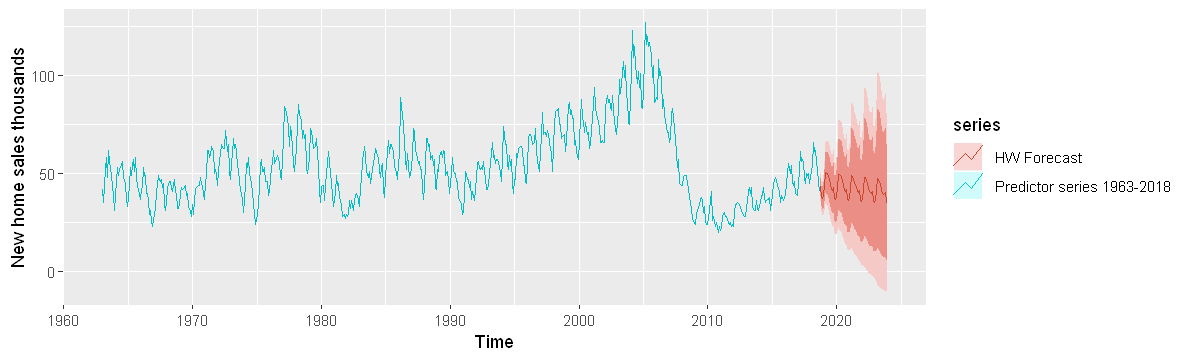

In [500]:
options(repr.plot.width = 10, repr.plot.height = 3)

hw_series=hw(series, seasonal="multiplicative", h=63)
autoplot(series, series=" Predictor series 1963-2018")+
autolayer(hw_series, series=" HW Forecast ")+ylab("New home sales thousands")